In [77]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
import os
import h5py
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 1000
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.cluster import adjusted_rand_score
dir = '/kaggle/input/a2data/'
out_dir = '/kaggle/working/'
batch_size = 64

In [26]:
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file):
        self.hdf5_file = hdf5_file
        
        # Open HDF5 file
        self.hdf5_handle = h5py.File(hdf5_file, 'r')
        self.data = self.hdf5_handle['images']
        self.images = [torch.tensor(self.data[i], dtype=torch.float32) / 255 for i in range(len(self.data))]
        self.masks = self.hdf5_handle['masks']
        self.masks = [torch.tensor(self.masks[i], dtype=torch.uint8) for i in range(len(self.masks))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

In [66]:
# train_dataset = HDF5Dataset(dir + 'train_dataset.h5')
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = HDF5Dataset(dir + 'val_dataset.h5')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

torch.Size([1, 128, 128])


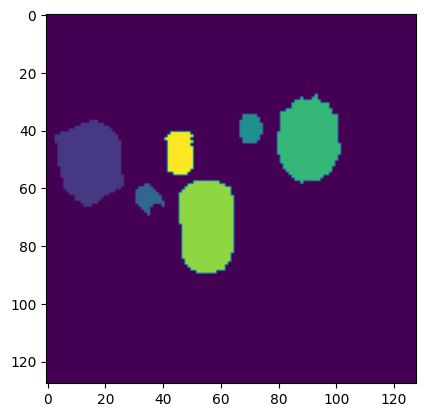

In [67]:
for i, (imgs, masks) in enumerate(val_loader):
    print(masks.shape)
    plt.imshow(masks[0])
    break

In [6]:
class SlotAttention(nn.Module):
    def __init__(self, k, d_common=64, n_iter_train=3,n_iter_test=5, d_slot=64, d_inputs=64, hid_dim=128):
        super(SlotAttention, self).__init__()
        self.k = k
        self.d_common = d_common
        self.n_iter_train = n_iter_train
        self.n_iter_test = n_iter_test
        self.d_slot = d_slot
        self.d_inputs = d_inputs

        self.fc_q = nn.Linear(d_slot, d_common)
        self.fc_k = nn.Linear(d_inputs, d_common)
        self.fc_v = nn.Linear(d_inputs, d_common)

        self.gru = nn.GRUCell(d_common, d_slot)
        self.mlp = nn.Sequential(
            nn.Linear(d_slot, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, d_slot)
        )

        self.softmax = nn.Softmax(dim=2)
        self.mu = nn.Parameter(torch.randn(1, 1,d_common))
        self.sigma = nn.Parameter(torch.rand(1,1, d_common))

    
    def forward(self, inputs):
        # inputs: (batch_size, n_inputs, d_inputs)
        # slots: (batch_size, n_slots, d_slot)
        if self.training:
            n_iter = self.n_iter_train
        else:
            n_iter = self.n_iter_test
        batch_size, n_inputs, d_inputs = inputs.size()
        mu = self.mu.expand(batch_size, self.k, -1)
        sigma = self.sigma.expand(batch_size, self.k, -1)
        slots = torch.normal(mu, sigma).to(device)
        inputs = nn.LayerNorm(d_inputs).to(device)(inputs)
        k = self.fc_k(inputs)               # (batch_size, n_inputs, d_common)
        v = self.fc_v(inputs)               # (batch_size, n_inputs, d_common)
        for i in range(n_iter):
            q = self.fc_q(nn.LayerNorm(self.d_slot).to(device)(slots))                # (batch_size, n_slots, d_common)

            attn = torch.bmm(k, q.permute(0, 2, 1)) / np.sqrt(self.d_common)            # (batch_size, n_inputs, n_slots)
            attn = self.softmax(attn) +  1e-8                                           # (batch_size, n_inputs, n_slots)
            attn = attn / attn.sum(dim=1, keepdim=True)                                 # (batch_size, n_inputs, n_slots)
            attn = attn.permute(0,2,1)
            updates = torch.einsum('bjd,bij->bid', v, attn)                             # (batch_size, n_slots, d_common)


            slots = self.gru(updates.reshape(-1,self.d_common), slots.reshape(-1, self.d_slot)).reshape(batch_size, self.k, self.d_slot)
            slots = nn.LayerNorm(self.d_slot).to(device)(slots)
            slots = slots + self.mlp(slots)
        
        return slots



In [7]:
class PositionalEmbeddings(nn.Module):
    def __init__(self, H, W, hid_dim=64):
        super(PositionalEmbeddings, self).__init__()
        self.H = H
        self.W = W
        self.hid_dim = hid_dim
        self.project = nn.Linear(4, hid_dim)
    
    def construct_grid(self, H, W):
        x = torch.linspace(0, 1, W).unsqueeze(0).repeat(H, 1)
        y = torch.linspace(0, 1, H).unsqueeze(1).repeat(1, W)
        return torch.stack([x, 1-x, y, 1-y], dim=2)    # (H, W, 4)


    def forward(self, inputs):
        grid = self.construct_grid(self.H, self.W).to(device)  # (H, W, 4)
        grid = self.project(grid)
        return inputs + grid.unsqueeze(0).expand(inputs.size(0), self.H, self.W, self.hid_dim)

In [8]:
class CNNEncoder(nn.Module):
    def __init__(self, hid_dim=64):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, hid_dim, 5, padding=2)                    
        self.conv2 = nn.Conv2d(hid_dim, hid_dim, 5, padding=2)
        self.conv3 = nn.Conv2d(hid_dim, hid_dim, 5, padding=2)
        self.conv4 = nn.Conv2d(hid_dim, hid_dim, 5, padding=2)

        self.positionalEmb = PositionalEmbeddings(128, 128, hid_dim)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(hid_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)  


    def forward(self, inputs):
        inputs = self.conv1(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv2(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv3(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv4(inputs)
        inputs = self.relu(inputs)
        
        inputs = self.positionalEmb(inputs.permute(0, 2, 3, 1))
        inputs = inputs.flatten(1, 2)
        inputs = nn.LayerNorm(inputs.size()[1:]).to(device)(inputs) 
        inputs = self.fc1(inputs)
        inputs = self.relu(inputs)
        inputs = self.fc2(inputs)
        return inputs
           

In [9]:
class deconvDecoder(nn.Module):
    def __init__(self, hid_dim=64):
        super(deconvDecoder, self).__init__()
        self.hid_dim = hid_dim
        self.deconv1 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, padding=2, output_padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, padding=2, output_padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, padding=2, output_padding=1, stride=2)
        self.deconv4 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, padding=2, output_padding=1, stride=2)
        self.deconv5 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, padding=2, output_padding=0, stride=1)
        self.deconv6 = nn.ConvTranspose2d(hid_dim, 4, 3, padding=1, output_padding=0, stride=1)

        self.relu = nn.ReLU()
        self.positionalEmb = PositionalEmbeddings(8, 8, hid_dim)

    def forward(self, slots):
        # slots: (batch_size, n_slots, d_slot)
        b, k, d = slots.size()
        slots = slots.unsqueeze(2).unsqueeze(3).expand(b, k, 8, 8, d)
        slots = slots.reshape(b*k, 8, 8, d)
        slots = self.positionalEmb(slots)
        slots = slots.permute(0, 3, 1, 2)
        slots = self.deconv1(slots)
        slots = self.relu(slots)
        slots = self.deconv2(slots)
        slots = self.relu(slots)
        slots = self.deconv3(slots)
        slots = self.relu(slots)
        slots = self.deconv4(slots)
        slots = self.relu(slots)
        slots = self.deconv5(slots)
        slots = self.relu(slots)
        slots = self.deconv6(slots)                 # (batch_size * n_slots, 4, 128, 128)

        slots = slots.reshape(b, k, 4, 128, 128)
        slots = slots.permute(0, 1, 3, 4, 2)
        contents, masks = slots.split([3, 1], dim=4)        # (batch_size, n_slots, 128, 128, 3)
        masks = nn.Softmax(dim=1)(masks)                    # (batch_size, n_slots, 128, 128, 1)
        img = (contents * masks).sum(dim=1)
        img = img.permute(0, 3, 1, 2)

        return img, masks
    
    def get_slot_imgs(self, slots, name):
        b, k, d = slots.size()
        slots = slots.unsqueeze(2).unsqueeze(3).expand(b, k, 8, 8, d)
        slots = slots.reshape(b*k, 8, 8, d)
        slots = self.positionalEmb(slots)
        slots = slots.permute(0, 3, 1, 2)
        slots = self.deconv1(slots)
        slots = self.relu(slots)
        slots = self.deconv2(slots)
        slots = self.relu(slots)
        slots = self.deconv3(slots)
        slots = self.relu(slots)
        slots = self.deconv4(slots)
        slots = self.relu(slots)
        slots = self.deconv5(slots)
        slots = self.relu(slots)
        slots = self.deconv6(slots)                 # (batch_size * n_slots, 4, 128, 128)

        slots = slots.reshape(b, k, 4, 128, 128)
        slots = slots.permute(0, 1, 3, 4, 2)
        contents, masks = slots.split([3, 1], dim=4)        # (batch_size, n_slots, 128, 128, 3)
        masks = nn.Softmax(dim=1)(masks)                    # (batch_size, n_slots, 128, 128, 1)
        img = torch.tensor((contents * masks) * 255, dtype=torch.uint8).cpu().numpy()
        img_dir = 'img_dir/'
        if(not os.path.exists(out_dir + img_dir)):
            os.makedirs(out_dir + img_dir)
        img_recon = torch.tensor(((contents * masks).sum(dim=1) * 255), dtype=torch.uint8).cpu().numpy()
        for i in range(b):
#             for j in range(k):
#                 img_name = name + '_slot' + str(j) + '_img' + str(i) + '.png'
#                 plt.imsave(out_dir + img_dir + img_name, img[i,j])
            plt.imsave(out_dir + img_dir + name + '_img' + str(i) + '_reconstructed.png', img_recon[i])
        


        

In [16]:
class SlotAttentionModel(nn.Module):
    def __init__(self, k, d_common=64, n_iter_train=3, n_iter_test=5, d_slot=64, d_inputs=64, hid_dim=64):
        super(SlotAttentionModel, self).__init__()
        self.encoder = CNNEncoder(hid_dim)
        self.slotAttention = SlotAttention(k, d_common, n_iter_train, n_iter_test, d_slot, d_inputs, hid_dim)
        self.decoder = deconvDecoder(hid_dim)
    
    def forward(self, inputs):
        features = self.encoder(inputs)
        slots = self.slotAttention(features)
        img, masks = self.decoder(slots)
        return img, masks
    
    def get_slot_imgs(self, inputs, name):
        features = self.encoder(inputs)
        slots = self.slotAttention(features)
        self.decoder.get_slot_imgs(slots, name)

In [ ]:
# load_model = True
# SAM = SlotAttentionModel(11, 64, 3, 5, 64, 64, 64)
# SAM = nn.DataParallel(SAM)
# SAM.to(device)
# if load_model:
#     SAM.load_state_dict(torch.load('/kaggle/input/modelv1/pytorch/v2/1/modelv1.pth'))
# criterion = nn.MSELoss()
# init_lr = 0.0004
# optimizer = optim.Adam(SAM.parameters(), lr=init_lr)


# warmup_iters = 10000
# decay_steps = 100000
# decay_rate = 0.5


In [116]:
def adjusted_rand_index(true_ids, pred_ids):
    """
    Args:
        true_masks: Integer ids for objects
            [batch_size, H, W].  
            as integer ids.
        pred_masks: An integer-valued array of shape
            [batch_size, K, H, W]. The predicted cluster assignment
            encoded as integer ids.
        ignore_background: Boolean, if True, then ignore all pixels where
            true_ids == 0 (default: False).

    Returns:
        ARI scores as a float32 array of shape [batch_size].
    """
    pred_ids = pred_ids.argmax(dim=-3)  # [B, N, H, W] --> [B, H, W]

    if len(true_ids.shape) == 3:
        true_ids = true_ids.unsqueeze(1)
    if len(pred_ids.shape) == 3:
        pred_ids = pred_ids.unsqueeze(1)
    true_oh = F.one_hot(true_ids).float()
    pred_oh = F.one_hot(pred_ids).float()
    N = torch.einsum("bthwc,bthwk->bck", true_oh, pred_oh)
    A = torch.sum(N, dim=-1)  # row-sum  (batch_size, c)
    B = torch.sum(N, dim=-2)  # col-sum  (batch_size, k)
    num_points = torch.sum(A, dim=1)

    rindex = torch.sum(N * (N - 1), dim=[1, 2])
    aindex = torch.sum(A * (A - 1), dim=1)
    bindex = torch.sum(B * (B - 1), dim=1)
    expected_rindex = aindex * bindex / torch.clamp(
        num_points * (num_points - 1), min=1)
    max_rindex = (aindex + bindex) / 2
    denominator = max_rindex - expected_rindex
    ari = (rindex - expected_rindex) / denominator

    # There are two cases for which the denominator can be zero:
    # 1. If both label_pred and label_true assign all pixels to a single cluster.
    #    (max_rindex == expected_rindex == rindex == num_points * (num_points-1))
    # 2. If both label_pred and label_true assign max 1 point to each cluster.
    #    (max_rindex == expected_rindex == rindex == 0)
    # In both cases, we want the ARI score to be 1.0:
    return torch.where(denominator != 0, ari, torch.tensor(1.).type_as(ari))

In [30]:
# torch.autograd.set_detect_anomaly(True)
# def train(model, criterion, optimizer, train_loader, num_epochs):
#     counter = 21700*2
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for i, (images) in enumerate(train_loader):
#             counter += 1
#             images = images.to(device)
#             if counter < warmup_iters:
#                 learning_rate = init_lr*(counter/warmup_iters)
#             else:
#                 learning_rate = init_lr
#             learning_rate = learning_rate * (decay_rate ** (counter/decay_steps))
#             optimizer.param_groups[0]['lr'] = learning_rate
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, images)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             if i % 10 == 9:
#                 print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
#                 running_loss = 0.0
#             del images, outputs, loss
#         torch.save(model.state_dict(), 'modelv2.pth')
#     print('Finished Training')

In [31]:
# train(SAM, criterion, optimizer, train_loader, n_epochs)

In [59]:
model = SlotAttentionModel(11, 64, 3, 5, 64, 64, 64)
model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/models-new/modelv2.pth'))

<All keys matched successfully>

In [107]:
def remove_background(true_masks, pred_masks):
    mask = (true_masks != 0)
    true_masks = true_masks[mask]
    pred_masks = pred_masks[mask]
    return true_masks, pred_masks

In [96]:
# print(remove_background(torch.tensor([[0,0,0],[1,1,0],[1,0,0]]), torch.tensor([[1,1,2],[0,1,1],[3,1,1]])))

(tensor([1, 1, 1]), tensor([0, 1, 3]))


In [105]:
# adjusted_rand_score(torch.tensor([1,2,2,2,2,4]), torch.tensor([1,4,3,3,3,2]))

0.5454545454545454

In [117]:
def calc_ARI(model, data_loader):
    model.eval()
    ARI = 0
    with torch.no_grad():
        for i, (images, true_masks) in enumerate(data_loader):
            print(i, end='\r')
            images = images.to(device)
            true_masks = true_masks.to(device)
            outputs, pred_masks = model(images)
            if ARI == 0:
                ARI = adjusted_rand_index(true_masks.long().cpu(), pred_masks.squeeze(-1).cpu())
            else:
                ARI += adjusted_rand_index(true_masks.long().cpu(), pred_masks.squeeze(-1).cpu())
#             pred_masks = torch.argmax(pred_masks.squeeze(-1), dim=1)
#             true_masks, pred_masks = remove_background(true_masks, pred_masks)
#             if i == 0:
#                 print(true_masks.shape, pred_masks.shape)
#             if ARI == 0:
#                 ARI = adjusted_rand_index(true_masks.long().cpu(), pred_masks.cpu())
#             else:
#                 ARI += adjusted_rand_index(true_masks.long().cpu(), pred_masks.cpu())
            del images, true_masks, outputs, pred_masks
    return ARI / len(data_loader)

In [118]:
print(calc_ARI(model, val_loader))

tensor([0.5439])


In [64]:
def K_mean(trained_model, data_loader, k):
    trained_model.eval()
    slots = []
    with torch.no_grad():
        for i, (images) in enumerate(data_loader):
            images = images.to(device)
            features = trained_model.module.encoder(images)
            slots.append(trained_model.module.slotAttention(features))
        slots = torch.cat(slots, dim=0)         # (n_samples, n_slots, d_slot)
        slots = slots.reshape(-1, slots.size(2))
        kmeans = KMeans(n_clusters=k).fit(slots.cpu().detach().numpy())
    return kmeans, slots

def get_slot_imgs(trained_model, kmeans, slots,  nval):
    trained_model.eval()
    samples = nval
    labels = torch.tensor(kmeans.labels_).flatten()
    for i in range(samples):
        print(i)
        sampled_slots = [0,0,0,0,0,0,0,0,0,0,0]
        for j in range(11):
            possible_slots = np.where(labels == j)[0]
            idx = np.random.choice(possible_slots)
            sampled_slots[j] = slots[idx]
        sampled_slots = torch.stack(sampled_slots, dim=0)
        sampled_slots = sampled_slots.unsqueeze(0)
        print(sampled_slots.shape)
        with torch.no_grad():
            trained_model.module.decoder.get_slot_imgs(sampled_slots, 'sample' + str(i))

In [ ]:
kmeans = K_mean(model, train_loader, 11)


In [ ]:
get_slot_imgs(model, kmeans[0], kmeans[1], 10000)

In [ ]:
# from matplotlib import pyplot as plt
# def pred(model, loader, num):
#     model.eval()
#     n = 0
#     for i, (images) in enumerate(loader):
#         n+=1
#         images = images.to(device)
#         outputs = model(images)
#         outputs = outputs.detach().cpu().numpy()
#         outputs = outputs * 255
#         outputs = outputs.astype(np.uint8)
#         images = images.detach().cpu().numpy()
#         images = images * 255
#         images = images.astype(np.uint8)

#         # save output images and images
#         for j in range(images.shape[0]):
#             plt.imsave(out_dir + 'reconstructed.png', outputs[j].transpose(1, 2, 0))
#             plt.imsave(out_dir + 'original.png', images[j].transpose(1, 2, 0))
#             n += 1
#             if n == num:
#                 break
            
#         if n == num:
#             break

In [ ]:
# pred(model, train_loader, 2)

In [ ]:
def pred(model, loader):
    model.eval()
    for i, (images) in enumerate(loader):
        images = images.to(device)
        model(images,"f")
        images = images.detach().cpu().numpy()
        images = images * 255
        images = images.astype(np.uint8)
        for b in range(images.shape[0]):
            plt.imsave(out_dir + 'img_dir/img' + str(b) + '_orig.png', images[b].transpose(1,2,0))
        break

In [ ]:
# pred(model, train_loader)

In [ ]:
# import shutil
# shutil.make_archive('img_dir_zipped', 'zip', '/kaggle/working/img_dir')